In [4]:
import os
import zipfile
import shutil
# Directory containing the zip files
directory = "dataset/sharpener"

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".zip"):
        # Extract the base name of the zip file (remove the .zip extension)
        base_foldername = filename[:-4]
        foldername = os.path.join(directory, base_foldername)
        
        # Create a directory with the base name
        os.makedirs(foldername, exist_ok=True)
        
        # Full path of the zip file
        zip_path = os.path.join(directory, filename)
        
        # Unzip the file into the corresponding directory
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for member in zip_ref.namelist():
                # Adjust the path to avoid creating redundant subfolders
                member_path = os.path.join(foldername, os.path.basename(member))
                source = zip_ref.open(member)
                target = open(member_path, "wb")
                with source, target:
                    shutil.copyfileobj(source, target)

print("Unzipping complete.")


Unzipping complete.


In [59]:
import os
import fnmatch

directory = "dataset/sharpener"
pattern = "wrist_rgb*_1.png"  # Adjust the pattern as needed

# Loop through all folders in the directory
for foldername in sorted(os.listdir(directory)):
    folder_path = os.path.join(directory, foldername)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if fnmatch.fnmatch(filename, pattern):
                file_path = os.path.join(folder_path, filename)
                print(f"Processing file: {file_path}")
                
                # Open the image
                # with Image.open(file_path) as img:
                #     img.show()


Processing file: dataset/sharpener/t0.03_rot15/wrist_rgb_t0.03_rot15_1.png
Processing file: dataset/sharpener/t0.03_rot30/wrist_rgb_t0.03_rot30_1.png
Processing file: dataset/sharpener/t0.03_rot45/wrist_rgb_t0.03_rot45_1.png
Processing file: dataset/sharpener/t0.03_rot60/wrist_rgb_t0.03_rot60_1.png
Processing file: dataset/sharpener/t0.03_rot75/wrist_rgb_t0.03_rot75_1.png
Processing file: dataset/sharpener/t0.06_rot15/wrist_rgb_t0.06_rot15_1.png
Processing file: dataset/sharpener/t0.06_rot30/wrist_rgb_t0.06_rot30_1.png
Processing file: dataset/sharpener/t0.06_rot45/wrist_rgb_t0.06_rot45_1.png
Processing file: dataset/sharpener/t0.06_rot60/wrist_rgb_t0.06_rot60_1.png
Processing file: dataset/sharpener/t0.06_rot75/wrist_rgb_t0.06_rot75_1.png
Processing file: dataset/sharpener/t0.09_rot15/wrist_rgb_t0.09_rot15_1.png
Processing file: dataset/sharpener/t0.09_rot30/wrist_rgb_t0.09_rot30_1.png
Processing file: dataset/sharpener/t0.09_rot45/wrist_rgb_t0.09_rot45_1.png
Processing file: dataset/

dict_keys(['keypoints', 'keypoint_scores', 'descriptors', 'image_size'])


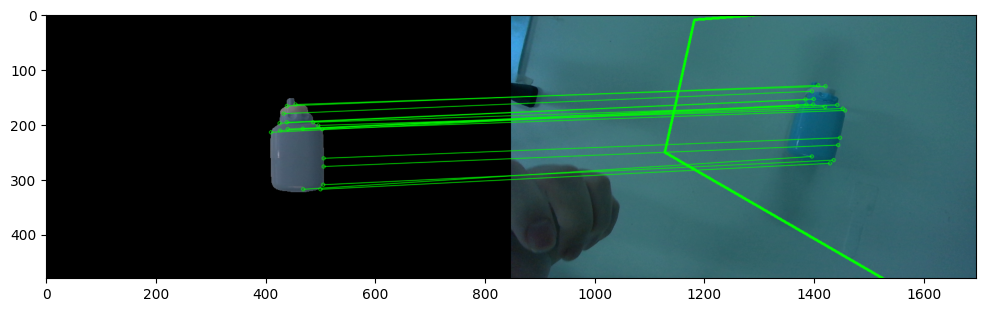

(<matplotlib.image.AxesImage at 0x2a2359110>, None)

In [53]:
import torch
import numpy as np
import poselib
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from lightglue import LightGlue, SuperPoint, match_pair

def numpy_image_to_torch(image: np.ndarray) -> torch.Tensor:
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float, device="cpu")

# SuperPoint+LightGlue
extractor = SuperPoint(max_num_keypoints=2048).eval().cpu()  # load the extractor
matcher = LightGlue(features='superpoint', depth_confidence=-1, width_confidence=-1).eval().cpu()  # load the matcher

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

seg = np.array(Image.open("dataset/sharpener/wrist_seg_ref.png")).astype(bool)
im1 = np.array(Image.open("dataset/sharpener/wrist_rgb_ref.png"))  # Original image
im1 *= seg
im2 = np.array(Image.open("dataset/sharpener/t0.03_rot15/wrist_rgb_t0.03_rot15_1.png"))
feats0, feats1, matches01 = match_pair(extractor, matcher, numpy_image_to_torch(im1), numpy_image_to_torch(im2))
print(feats0.keys())
matches = matches01['matches']  # indices with shape (K,2)
mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)
canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas), plt.show()

In [166]:
from scipy.spatial.transform import Rotation

K = np.load("handeye/intrinsics_d405.npy")
camera = {'model': 'PINHOLE', 'width': 848, 'height': 480, 'params': [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]}

def normalize_points(points, K):
    # Step 1: Camera intrinsics normalization
    K_inv = np.linalg.inv(K)
    normalized_points = (K_inv @ np.hstack((points, np.ones((points.shape[0], 1)))).T).T[:, :2]
    
    # Step 2: Hartley normalization
    # Calculate centroid
    centroid = np.mean(normalized_points, axis=0)
    
    # Center the points
    centered_points = normalized_points - centroid
    
    # Calculate average distance from origin
    avg_distance = np.mean(np.linalg.norm(centered_points, axis=1))
    
    # Scale factor to achieve average distance of sqrt(2)
    scale = np.sqrt(2) / avg_distance
    
    # Apply scaling
    hartley_normalized_points = centered_points * scale
    
    # Create transformation matrix
    T = np.array([
        [scale, 0, -scale*centroid[0]],
        [0, scale, -scale*centroid[1]],
        [0, 0, 1]
    ])
    
    return hartley_normalized_points, T


# Normalize your points
mkpts_0_norm, T1 = normalize_points(mkpts_0, K)
mkpts_1_norm, T2 = normalize_points(mkpts_1, K)

# Use RANSAC and check different methods
E, mask = cv2.findEssentialMat(mkpts_0_norm, mkpts_1_norm, np.eye(3), method=cv2.RANSAC, prob=0.999, threshold=0.001)

# Recover pose
n, R, t, _ = cv2.recoverPose(E, mkpts_0_norm, mkpts_1_norm, np.eye(3), mask=mask)

# Scale t to match your known translation magnitude (if available)
known_translation_magnitude = 0.03  # 3cm
t_scaled = t * (known_translation_magnitude / np.linalg.norm(t))

print("Estimated translation:", t_scaled)
print("Estimated rotation (Euler angles):", Rotation.from_matrix(R).as_euler('xyz', degrees=True))

# Check essential matrix properties
U, S, Vt = np.linalg.svd(E)
print("Singular values of E:", S)

M, info = poselib.estimate_relative_pose(
    mkpts_0,
    mkpts_1,
    camera,
    camera,
    {
        "max_epipolar_error": 0.5,
    },
)
print(M, info)

def estimate_pose(kpts0, kpts1, K0, K1, thresh=0.5, conf=0.99999):
    if len(kpts0) < 5:
        return None
    
    # normalize keypoints
    kpts0 = (kpts0 - K0[[0, 1], [2, 2]][None]) / K0[[0, 1], [0, 1]][None]
    kpts1 = (kpts1 - K1[[0, 1], [2, 2]][None]) / K1[[0, 1], [0, 1]][None]

    # normalize ransac threshold
    ransac_thr = thresh / np.mean([K0[0, 0], K1[1, 1], K0[0, 0], K1[1, 1]])

    # compute pose with cv2
    E, mask = cv2.findEssentialMat(
        kpts0, kpts1, np.eye(3), threshold=ransac_thr, prob=conf, method=cv2.RANSAC)
    if E is None:
        print("\nE is None while trying to recover pose.\n")
        return None

    # recover pose from E
    best_num_inliers = 0
    ret = None
    for _E in np.split(E, len(E) / 3):
        n, R, t, _ = cv2.recoverPose(_E, kpts0, kpts1, np.eye(3), 1e9, mask=mask)
        if n > best_num_inliers:
            ret = (R, t[:, 0], mask.ravel() > 0)
            best_num_inliers = n

    return ret

ret = estimate_pose(mkpts_0, mkpts_1, K, K)
print(ret[1] * 0.03, Rotation.from_matrix(ret[0]).as_euler('xyz', degrees=True))


Estimated translation: [[ 0.02710156]
 [-0.00905052]
 [ 0.00914293]]
Estimated rotation (Euler angles): [-3.61517882 -0.85373896 33.6068659 ]
Singular values of E: [7.07106781e-01 7.07106781e-01 5.28648842e-15]
[q:  0.962804 0.0679933  0.106666  0.238763, t:   0.700732 -0.0559291   0.711367] {'refinements': 13, 'iterations': 1538, 'num_inliers': 18, 'inlier_ratio': 0.46153846153846156, 'model_score': 3.1806641727971306e-05, 'inliers': [False, True, True, True, False, False, True, True, False, True, False, True, True, True, True, False, True, True, False, False, False, True, False, False, True, False, False, False, True, False, False, True, False, False, True, False, False, True, False]}
[ 0.00205911 -0.00741972  0.02899496] [15.48318587 18.32135805 35.39010845]


In [181]:
def select_best_decomposition(decompositions):
    Rs, ts, normals = decompositions[1], decompositions[2], decompositions[3]
    best_index = -1
    best_score = float('inf')

    for i, (R, t, n) in enumerate(zip(Rs, ts, normals)):
        # # Heuristic 1: Check the magnitude of the translation vector (consider all components)
        # translation_magnitude = np.linalg.norm(t)

        # # Heuristic 2: Ensure the normal is close to [0, 0, 1]
        # normal_deviation = np.linalg.norm(n - np.array([0, 0, 1]))

        # Heuristic 3: Check the rotation matrix (for dominant yaw)
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2))
        roll = np.arctan2(R[2, 1], R[2, 2])

        # Ideally, pitch and roll should be small in a top-down view
        rotation_score = np.abs(pitch) + np.abs(roll)

        # Combine heuristics into a single score
        score = rotation_score

        if score < best_score:
            best_score = score
            best_index = i

    if best_index != -1:
        best_R = Rs[best_index]
        best_t = ts[best_index]
        best_normal = normals[best_index]
    else:
        print("No valid decomposition found.")

    return Rotation.from_matrix(best_R).as_euler('xyz', degrees=True), best_t


H, mask = cv2.findHomography(mkpts_0_norm, mkpts_1_norm, cv2.USAC_MAGSAC, 0.001)
H = np.linalg.inv(T2) @ H @ T1
decompositions = cv2.decomposeHomographyMat(H, np.eye(3))
best_R, best_t = select_best_decomposition(decompositions)
best_R, best_t

H - H.T

array([[ 0.        , -0.9910129 ,  0.64609459],
       [ 0.9910129 ,  0.        ,  0.00099229],
       [-0.64609459, -0.00099229,  0.        ]])

In [184]:
# Compute the determinant of H
det_H = np.linalg.det(H)
# Compute the ratio Z/Z*
# Note: Z/Z* = (det(H))^(-1/3)
Z_ratio = det_H ** (-1/3)
# Compute the error using natural logarithm
e_z = np.log(Z_ratio)
e_z

0.040103037341307726

In [180]:
import json
with open(f"experiments/pencile_sharpener/demo_bottlenecks.json") as f:
    dbn = json.load(f)


m = np.array(dbn['bottleneck_left'][:3])
m / m[2]
H

array([[ 0.75898534, -0.51092769,  0.36099819],
       [ 0.48008521,  0.76128805, -0.0968049 ],
       [-0.28509641, -0.09779719,  1.02847237]])

In [293]:
quat = np.append(M.q[1:], M.q[0])
quat

array([0., 0., 0., 1.])

In [144]:
print(M.t * 0.03, Rotation.from_quat(quat).as_euler('xyz', degrees=True))

[-0.00769267 -0.01221167  0.02630015] [17.81946491 40.95855356 39.67719762]


In [170]:
from scipy.spatial.transform import Rotation
from tqdm import tqdm

seg = np.array(Image.open("dataset/sharpener/wrist_seg_ref.png")).astype(bool)
im1 = np.array(Image.open("dataset/sharpener/wrist_rgb_ref.png")) # Original image
im1 *= seg
# xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = True, top_k = 2048)
K = np.load("handeye/intrinsics_d405.npy")

camera = {'model': 'PINHOLE', 'width': 848, 'height': 480, 'params': [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]}

t = []
R = []
t_cv = []
R_cv = []
t_ho = []
R_ho = []
index_t = 0.03
index_r = 30
for i in tqdm(range(50), desc="Processing"):
    im2 = np.copy(Image.open(f"dataset/sharpener/t{index_t}_rot{index_r}/wrist_rgb_t{index_t}_rot{index_r}_{i+1}.png"))
    feats0, feats1, matches01 = match_pair(extractor, matcher, numpy_image_to_torch(im1), numpy_image_to_torch(im2))
    matches = matches01['matches']  # indices with shape (K,2)
    mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
    mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)
    M, info = poselib.estimate_relative_pose(
        mkpts_0,
        mkpts_1,
        camera,
        camera,
        {
            "max_epipolar_error": 0.5,
        },
    )
    print(M)
    t.append(M.t)
    quat = np.append(M.q[1:], M.q[0])
    R.append(Rotation.from_quat(quat).as_euler('xyz', degrees=True))

    mkpts_0_norm, T1 = normalize_points(mkpts_0, K)
    mkpts_1_norm, T2 = normalize_points(mkpts_1, K)

    # Use RANSAC and check different methods
    E, mask = cv2.findEssentialMat(mkpts_0_norm, mkpts_1_norm, np.eye(3), method=cv2.RANSAC, prob=0.999, threshold=0.001)

    # Recover pose
    n, rotation, translation, _ = cv2.recoverPose(E, mkpts_0_norm, mkpts_1_norm, np.eye(3), mask=mask)
    R_cv.append(Rotation.from_matrix(rotation).as_euler('xyz', degrees=True))
    t_cv.append(translation)

    H, mask = cv2.findHomography(mkpts_0_norm, mkpts_1_norm, cv2.USAC_MAGSAC, 0.001)
    H = np.linalg.inv(T2) @ H @ T1
    decompositions = cv2.decomposeHomographyMat(H, np.eye(3))
    best_R, best_t = select_best_decomposition(decompositions)

    R_ho.append(best_R)
    t_ho.append(best_t)


Processing:   2%|▏         | 1/50 [00:04<03:19,  4.07s/it]

[q:  0.875899 0.0707344  0.414294  0.236978, t: -0.493097 -0.290464   0.82028]


Processing:   4%|▍         | 2/50 [00:07<03:04,  3.85s/it]

[q: 0.950666 0.088928 0.175614 0.239762, t:  0.0986691 -0.0982757   0.990288]


Processing:   6%|▌         | 3/50 [00:11<02:54,  3.71s/it]

[q:  0.96343 0.100238 0.141123 0.204548, t: 0.350114 0.308914 0.884317]


Processing:   8%|▊         | 4/50 [00:14<02:43,  3.55s/it]

[q:  0.930552 0.0632484  0.247565  0.262266, t: -0.0518507  -0.304928   0.955033]


Processing:  10%|█         | 5/50 [00:17<02:36,  3.47s/it]

[q:  0.969384 0.0630047 0.0172993  0.236696, t:  0.932116 0.0569525  0.359309]


Processing:  12%|█▏        | 6/50 [00:21<02:29,  3.40s/it]

[q:  0.965713  0.067826 0.0756515  0.238903, t:    0.82736 0.00490098   0.562877]


Processing:  14%|█▍        | 7/50 [00:24<02:25,  3.37s/it]

[q:  0.967845 0.0377469 0.0513625  0.243336, t:  0.856039 -0.159462  0.491861]


Processing:  16%|█▌        | 8/50 [00:27<02:21,  3.38s/it]

[q:   0.90887 0.0423993 -0.395371  0.125854, t: 0.958374 0.103218  0.26687]


Processing:  18%|█▊        | 9/50 [00:31<02:20,  3.42s/it]

[q:  0.91915 0.087944 0.286196 0.255969, t:  -0.32784 -0.213311  0.920716]


Processing:  20%|██        | 10/50 [00:34<02:15,  3.38s/it]

[q: 0.953047 0.104075 0.104113 0.264634, t: 0.629078 0.147195 0.763387]


Processing:  22%|██▏       | 11/50 [00:38<02:10,  3.36s/it]

[q: 0.934478 0.103626 0.225507 0.255265, t:  -0.190137 -0.0864057   0.979743]


Processing:  24%|██▍       | 12/50 [00:41<02:06,  3.34s/it]

[q: 0.930353 0.101854 0.235308 0.262107, t: -0.218345 -0.126475  0.967694]


Processing:  26%|██▌       | 13/50 [00:44<02:03,  3.33s/it]

[q:  0.884264 0.0304114  0.395899    0.2458, t: -0.263374 -0.347567  0.900048]


Processing:  28%|██▊       | 14/50 [00:48<02:00,  3.35s/it]

[q:  0.957479 0.0289789 -0.120327  0.260606, t:  0.986575 0.0292618  0.160798]


Processing:  30%|███       | 15/50 [00:51<01:58,  3.40s/it]

[q:  0.948728 0.0742978  0.168574   0.25686, t:  0.302128 -0.176974   0.93673]


Processing:  32%|███▏      | 16/50 [00:54<01:56,  3.41s/it]

[q:  0.956108 0.0627376  0.179249   0.22314, t:  0.285771 -0.186992  0.939959]


Processing:  34%|███▍      | 17/50 [00:58<01:52,  3.42s/it]

[q:  0.949716 0.0779244   0.16005  0.257588, t:  0.313985 -0.166118  0.934787]


Processing:  36%|███▌      | 18/50 [01:01<01:50,  3.44s/it]

[q:  0.921303 0.0875603  0.290046  0.243737, t: -0.341793 -0.189551  0.920779]


Processing:  38%|███▊      | 19/50 [01:05<01:47,  3.47s/it]

[q:  0.952972 0.0729573  0.165457  0.243198, t:   0.29805 -0.170051  0.939322]


Processing:  40%|████      | 20/50 [01:08<01:44,  3.50s/it]

[q:  0.948899 0.0658188  0.198256  0.236544, t:  0.175178 -0.212052  0.961456]


Processing:  42%|████▏     | 21/50 [01:12<01:42,  3.54s/it]

[q: 0.948363 0.127127 0.178888 0.229011, t: -0.102927  0.324073  0.941015]


Processing:  44%|████▍     | 22/50 [01:15<01:37,  3.48s/it]

[q:   0.63819 -0.055807  0.714336  0.281643, t: -0.195608 -0.372689  0.907316]


Processing:  46%|████▌     | 23/50 [01:19<01:32,  3.43s/it]

[q:  0.947854 0.0742434  0.164354  0.262772, t:  0.293774 -0.197342  0.935304]


Processing:  48%|████▊     | 24/50 [01:22<01:28,  3.42s/it]

[q:    0.9221 -0.035454 -0.347328  0.166845, t:   0.959073 -0.0259043   0.283297]


Processing:  50%|█████     | 25/50 [01:26<01:31,  3.66s/it]

[q:  0.968852 0.0613407  0.124937  0.204828, t:     0.5699 -0.0914803    0.81705]


Processing:  52%|█████▏    | 26/50 [01:30<01:29,  3.72s/it]

[q:   0.963545   0.122166 -0.0207725   0.237117, t: 0.867089 0.319948 0.381999]


Processing:  54%|█████▍    | 27/50 [01:34<01:22,  3.58s/it]

[q:   0.820099 -0.0261645    0.49829   0.280109, t: -0.282023 -0.438839  0.853178]


Processing:  56%|█████▌    | 28/50 [01:37<01:16,  3.48s/it]

[q:    0.9739 0.0869175 0.0242055  0.208275, t: 0.823075 0.119778 0.556361]


Processing:  58%|█████▊    | 29/50 [01:40<01:12,  3.45s/it]

[q:  0.948964 0.0701445  0.180671  0.248807, t:   0.24712 -0.198999  0.948335]


Processing:  60%|██████    | 30/50 [01:43<01:07,  3.38s/it]

[q:  0.815466 0.0932684  0.512016   0.25329, t: -0.438845 -0.231002  0.868442]


Processing:  62%|██████▏   | 31/50 [01:47<01:03,  3.34s/it]

[q:  0.862419 0.0110407  0.424622  0.275332, t: -0.288319   -0.4145  0.863253]


Processing:  64%|██████▍   | 32/50 [01:50<00:59,  3.31s/it]

[q:  0.811668 0.0277302  0.514634  0.274915, t: -0.347448 -0.359902  0.865906]


Processing:  66%|██████▌   | 33/50 [01:53<00:56,  3.30s/it]

[q:  0.946823 0.0705336  0.184079  0.254294, t:  0.241788 -0.203009  0.948981]


Processing:  68%|██████▊   | 34/50 [01:57<00:53,  3.33s/it]

[q:   0.446092 -0.0102797   0.861104   0.243714, t: -0.067722  -0.26986  0.960689]


Processing:  70%|███████   | 35/50 [02:00<00:50,  3.37s/it]

[q:  0.962789 0.0756829  0.139562  0.218706, t:   0.482875 -0.0732485   0.872621]


Processing:  72%|███████▏  | 36/50 [02:03<00:46,  3.35s/it]

[q: 0.963949 0.151088 0.133032 0.174004, t: 0.0644736  0.921755  0.384289]


Processing:  74%|███████▍  | 37/50 [02:07<00:44,  3.41s/it]

[q:  0.958998 0.0679475  0.131265  0.241818, t:  0.562004 -0.114409  0.819223]


Processing:  76%|███████▌  | 38/50 [02:10<00:40,  3.39s/it]

[q:   0.960567 -0.0358136  -0.132573   0.241771, t:  0.967943 -0.153899  0.198921]


Processing:  78%|███████▊  | 39/50 [02:13<00:36,  3.33s/it]

[q:  0.964703 0.0476094  0.158888   0.20454, t:  0.244033 -0.332597  0.910973]


Processing:  80%|████████  | 40/50 [02:17<00:33,  3.33s/it]

[q:   0.9366 0.081339 0.195889 0.278912, t:  0.014055 -0.247693   0.96894]


Processing:  82%|████████▏ | 41/50 [02:20<00:29,  3.29s/it]

[q: 0.935636 0.083323 0.240286 0.244756, t: -0.183958 -0.182916  0.965991]


Processing:  84%|████████▍ | 42/50 [02:23<00:26,  3.29s/it]

[q:  0.961177 0.0727165 0.0897951  0.250574, t:   0.751947 -0.0169322   0.660053]


Processing:  86%|████████▌ | 43/50 [02:26<00:22,  3.27s/it]

[q:  0.93523 0.074564 0.203781 0.279748, t: 0.0700912 -0.270436   0.96185]


Processing:  88%|████████▊ | 44/50 [02:30<00:19,  3.25s/it]

[q:  0.947273 0.0400116 -0.194914  0.251158, t: 0.976541  0.09769 0.191952]


Processing:  90%|█████████ | 45/50 [02:33<00:16,  3.24s/it]

[q:  0.959152 0.0721888  0.111935  0.249573, t:   0.643344 -0.0660475   0.762853]


Processing:  92%|█████████▏| 46/50 [02:36<00:12,  3.24s/it]

[q:  0.940487 0.0917328  0.197108  0.261184, t: -0.012299 -0.135321   0.99156]


Processing:  94%|█████████▍| 47/50 [02:39<00:09,  3.25s/it]

[q:  0.966075 0.0645044 0.0655886  0.241322, t:    0.859141 -0.00408609    0.513435]


Processing:  96%|█████████▌| 48/50 [02:43<00:06,  3.23s/it]

[q:  0.882876 0.0720825  0.381536  0.264128, t: -0.446947 -0.294126  0.844992]


Processing:  98%|█████████▊| 49/50 [02:46<00:03,  3.22s/it]

[q:  0.961576 0.0696919  0.107445  0.242838, t:   0.670518 -0.0617345   0.739829]


Processing: 100%|██████████| 50/50 [02:49<00:00,  3.39s/it]

[q:  0.962804 0.0679933  0.106666  0.238763, t:   0.700732 -0.0559291   0.711367]


In [174]:
R = np.array(R)
t = np.array(t)

np.mean(R, axis=0), np.mean(t, axis=0), np.std(R, axis=0), np.std(t, axis=0)

# (array([18.02187308, 16.81708633, 36.84062749]),
#  array([ 0.27540846, -0.10215688,  0.76572458]),
#  array([22.64265037, 21.94607351, 23.06821162]),
#  array([0.46340621, 0.22898964, 0.24675456]))

(array([18.02187308, 16.81708633, 36.84062749]),
 array([ 0.27540846, -0.10215688,  0.76572458]),
 array([22.64265037, 21.94607351, 23.06821162]),
 array([0.46340621, 0.22898964, 0.24675456]))

In [177]:
R_cv = np.array(R_cv)
t_cv = np.array(t_cv)

np.mean(R_cv, axis=0), np.mean(t_cv, axis=0), np.std(R_cv, axis=0), np.std(t_cv, axis=0)

# (array([19.5949028 , 19.9342976 , 39.11387051]),
#  array([[ 0.23806853],
#         [-0.15327189],
#         [ 0.80912536]]),
#  array([23.54891266, 23.81308333, 24.59231467]),
#  array([[0.42384873],
#         [0.20284853],
#         [0.21059913]]))

(array([ 1.95305956,  2.21036306, 25.36489173]),
 array([[ 0.22339739],
        [-0.07469783],
        [ 0.1277071 ]]),
 array([ 8.39496219,  5.76949718, 11.65325722]),
 array([[0.71953745],
        [0.43604409],
        [0.46939977]]))

In [179]:
R_ho = np.array(R_ho)
t_ho = np.array(t_ho)

np.mean(R_ho, axis=0), np.mean(t_ho, axis=0), np.std(R_ho, axis=0), np.std(t_ho, axis=0)

# (array([ 2.88616173, 11.71122287, 31.10718736]),
#  array([[ 0.24365149],
#         [-0.13091224],
#         [ 0.31746778]]),
#  array([13.54431918,  6.50548418,  3.48052118]),
#  array([[0.33770307],
#         [0.21851093],
#         [0.70919047]]))

(array([ 3.65711155, 11.80167169, 31.2822797 ]),
 array([[ 0.22677518],
        [-0.11256958],
        [ 0.29062484]]),
 array([13.31584332,  6.34611056,  3.33054917]),
 array([[0.31165117],
        [0.21857502],
        [0.66680132]]))

In [ ]:
import numpy as np

def angular_error(R_gt, R_est):
    # Compute the relative rotation matrix
    R_rel = np.dot(R_gt.T, R_est)
    
    # Compute the trace of the relative rotation matrix
    trace_R_rel = np.trace(R_rel)
    
    # Compute the angle of rotation
    theta = np.arccos((trace_R_rel - 1) / 2)
    
    # Convert radians to degrees if needed
    theta_deg = np.degrees(theta)
    
    return theta_deg

# Example rotation matrices (replace these with your actual matrices)
R_gt = Rotation.from_euler([0, 0, 30])
R_est = np.array([[0.866, -0.5, 0],
                  [0.5, 0.866, 0],
                  [0, 0, 1]])  # Estimated rotation matrix

# Compute the angular error
error = angular_error(R_gt, R_est)
print(f"Angular Error: {error:.2f} degrees")


In [205]:
import pickle

# Save the dictionary to a pickle file
with open("dataset/sharpener/lg_Essential.pkl", "wb") as file:
    pickle.dump(lg_Essential, file)

In [210]:
# Load the dictionary from the pickle file
with open("dataset/sharpener/lg_Essential.pkl", "rb") as file:
    lg_Essential_loaded = pickle.load(file)

# Accessing the loaded data
R_loaded = lg_Essential_loaded["0, 0"]["R"]
t_loaded = lg_Essential_loaded["0, 0"]["t"]

print("Loaded Rotation Matrix R:\n", R_loaded)
print("Loaded Translation Vector t:\n", t_loaded)

Loaded Rotation Matrix R:
 [[9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e

In [349]:
torch.backends.mps.is_available()

True

In [354]:
from mini_dust3r.api import OptimizedResult, inferece_dust3r, log_optimized_result
from mini_dust3r.model import AsymmetricCroCo3DStereo
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = AsymmetricCroCo3DStereo.from_pretrained(
    "nielsr/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
).to(device)


def main(image_dir):

    optimized_results: OptimizedResult = inferece_dust3r(
        image_dir_or_list=image_dir,
        model=model,
        device=device,
        batch_size=1,
    )

    return optimized_results

In [358]:
model 

In [356]:
res = main(["dataset/sharpener/wrist_rgb_ref.png", "dataset/sharpener/t0.12_rot75/wrist_rgb_t0.12_rot75_1.png"])

>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot75/wrist_rgb_t0.12_rot75_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs


100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


  - conf=5.07 for edge 0-1
  - conf=5.78 for edge 1-0


100%|██████████| 2/2 [00:00<00:00, 26.83it/s]


In [350]:
res.world_T_cam_b44

array([[[ 9.9999660e-01, -2.2535659e-03,  1.3307873e-03, -4.0668889e-04],
        [ 2.2547205e-03,  9.9999708e-01, -8.6675788e-04,  3.3012775e-04],
        [-1.3288301e-03,  8.6975546e-04,  9.9999875e-01,  3.0780442e-03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],

       [[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]],
      dtype=float32)

In [2]:
Rotation.from_matrix(res.world_T_cam_b44[0, :3, :3]).as_euler('xyz', degrees=True)

NameError: name 'Rotation' is not defined